In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import gc
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from random import shuffle
from scipy.stats import spearmanr

from access_biology_data import lincs, properties
from access_science_shared import standardizer

sys.path.append('./../src/')
from aging_tools import inout, export

from access_biology_data import annotation
from access_biology_data import meta

In [4]:
from narrative import nar181026_heat_confidence_genes



In [5]:
outfolder = '220217_across_tissues'
infolder = '200611_manually_curated_overview_of_tissues'

In [6]:
save_images = False

In [7]:
from natsort import natsorted

In [8]:
agg_collect_studies = []

# This study

In [9]:
ref_genes = standardizer.reference_genes(10090, 'orp')

pr = properties.genbank_validated_rna(10090)[
    ['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']
].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])
pr = pr[pr['gene_ncbi'].isin(ref_genes)]

all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')


tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 

all_de = all_de[
    (all_de['tissue'].isin(tissues_to_consider)) & 
    (all_de['pfu']==0) &
    (all_de['gene_ncbi'].isin(ref_genes)) & 
    (all_de['padj'].notnull()) &
    (all_de['younger']==4)
]

conditions = natsorted(all_de['condition'].unique())

out = pd.DataFrame(index=conditions, columns=[
    'corr', 'pval'
]).rename_axis('condition')

for condition in conditions:
    d = all_de[
        (all_de['de_unit']=='both') & (all_de['condition']==condition)
    ]

    d = d[['gene_ncbi', 'o_over_y']].dropna()
    d = pd.merge(d, pr)

    r, p = spearmanr(d['log_length'], d['o_over_y'])
    d = d.set_index('gene_ncbi')

    out.loc[condition, 'corr'] = r
    out.loc[condition, 'pval'] = p
    
out = out.reset_index()

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [10]:
a = pd.merge(
    out,
    all_de[['condition', 'tissue', 'older']].drop_duplicates()
)

In [11]:
a = a[a['older']==24][['tissue', 'corr', 'pval']]

In [12]:
a.loc[:, 'source'] = 'This study'

In [13]:
renamer = {
        'Adrenal': 'Adrenal Gland', 
        'BAT': 'Adipose - Brown', 
        'Blood': 'Blood - Blood', 
        'Brain': 'Brain - Frontal cortex', 
        'Esophagus': 'Esophagus', 
        'GutEP': 'Bowel - Gut epithelium', 
        'Heart': 'Heart',
        'Kidney': 'Kidney', 
        'LI': 'Bowel - Large intestine', 
        'Liver': 'Liver', 
        'Lung': 'Lung', 
        'MuscSat': 'Muscle - Muscle', 
        'SI': 'Bowel - Small intestine', 
        'Skin': 'Skin',
        'Stomach': 'Stomach', 
        'WAT': 'Adipose - White', 
        'Cerebellum': 'Brain - Cerebellum'
}
    

In [14]:
a['tissue'] = a['tissue'].replace(renamer)

In [15]:
a = a.rename(columns={'corr': 'effect'})

In [16]:
agg_collect_studies.append(a)

# Schaum et al.

In [17]:
from access_science_shared import mapper

In [18]:
taxon_id = 10090
ref_genes = standardizer.reference_genes(taxon_id, 'orp')
pr = properties.genbank_validated_rna(taxon_id)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])
pr = pr[pr['gene_ncbi'].isin(ref_genes)]

p_base = inout.get_internal_path('dynamic/tstoeger/200501_schaum')
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(p_base) if isfile(join(p_base, f))]

drawer = pd.Series(onlyfiles).to_frame('filename')
drawer['tissue'] = drawer['filename'].str.extract('(.*)_[0-9]+_vs')
drawer['first'] = drawer['filename'].str.extract('.*_([0-9]+)_vs').astype(float)
drawer['last'] = drawer['filename'].str.extract('.*_[0-9]+_vs_([0-9]+)').astype(float)
drawer['tissue'] = drawer['tissue'].str.replace('_', ' ')

young_age = 3
ages = [int(x) for x in sorted(drawer[drawer['last']>young_age]['last'].unique())]
tissues = drawer['tissue'].unique()
organizer = drawer[
    (drawer['first'].isin(ages)) & 
    (drawer['last']==young_age) 
].rename(columns={'first': 'older', 'last': 'younger'}).reset_index(drop=True)

out_rho = pd.DataFrame(index=tissues, columns=ages)
out_pvalue = pd.DataFrame(index=tissues, columns=ages)

for j in organizer.index:
    filename = organizer.loc[j, 'filename']
    tissue =  organizer.loc[j, 'tissue']
    older =  organizer.loc[j, 'older']

    p = os.path.join(p_base, filename)

    df = pd.read_csv(
        p, usecols=['gene_ID', 'log2FoldChange', 'pvalue', 'padj']
    ).sort_values('gene_ID').rename(columns={'gene_ID': 'gene_ensembl'}).dropna(
    subset=['log2FoldChange'])
    
    df = mapper.gene_ensembl_2_gene_ncbi_unambiguously(df, 10090).reset_index()
    
    df = pd.merge(df, pr)
    rho, pval = spearmanr(df['log_length'], df['log2FoldChange'])
    
    
    out_rho.loc[tissue, older] = rho
    out_pvalue.loc[tissue, older] = pval

In [19]:
a = pd.concat([
    out_rho.loc[:, 24].to_frame('corr').rename_axis('tissue'),
    out_pvalue.loc[:, 24].to_frame('pval').rename_axis('tissue')
], axis=1).reset_index()

In [20]:
a.loc[:, 'source'] = 'Schaum et al.'

In [21]:
a['tissue'].unique()

array(['Subcutaneous Fat', 'Liver', 'Kidney', 'Marrow', 'Small Intestine',
       'Brain', 'Mesenteric Fat', 'Heart', 'Gonadal Fat', 'Spleen',
       'Brown Fat', 'Limb Muscle', 'Lung', 'Skin', 'White Blood Cells',
       'Bone', 'Pancreas'], dtype=object)

In [22]:
renamer = {
    'Subcutaneous Fat': 'Adipose - Subcutaneous', 
    'Small Intestine': 'Bowel - Small intestine',
    'Brain': 'Brain - Brain', 
    'Mesenteric Fat': 'Adipose - Mesenteric', 
    'Gonadal Fat': 'Adipose - Gonadal',
    'Brown Fat': 'Adipose - Brown', 
    'Limb Muscle': 'Muscle - Limb muscle', 
    'White Blood Cells': 'Blood - White blood cells',
}
    

In [23]:
a['tissue'] = a['tissue'].replace(renamer)

a = a.rename(columns={'corr': 'effect'})
agg_collect_studies.append(a)

# Benayoun

In [24]:
pr = properties.genbank_validated_rna(10090)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])

In [25]:
ref_genes = standardizer.reference_genes(10090, 'orp')


In [26]:
pr = pd.merge(pr, meta.gene_info(10090, ['gene_ncbi', 'symbol_ncbi']))

In [27]:
from scipy.stats import mannwhitneyu

In [28]:
tissues = {
    'tissue_independent': 'A',
    'heart': 'B',
    'liver': 'C',
    'cerebellum': 'D',
    'olfactory_bulb': 'E', 
    
}

In [29]:
results = []

for tissue in tissues.keys():

    p = '/Users/tstoeger/Dropbox/aging_map_paper/datasets/general/resources/publications/benayoun_2019/Supplemental_Table_S4.xlsx'

    df = pd.read_excel(p, tissues[tissue],header=1).rename(columns={'Gene Name': 'symbol_ncbi'})

    prc = pr.copy()


    f = prc['symbol_ncbi'].isin(
        df[df['Age change']=='UP']['symbol_ncbi'])
    prc.loc[f, 'direction'] = 'up'

    f = prc['symbol_ncbi'].isin(
        df[df['Age change']=='DOWN']['symbol_ncbi'])
    prc.loc[f, 'direction'] = 'down'
    
    pv = mannwhitneyu(
        prc[prc['direction']=='down']['log_length'],
        prc[prc['direction']=='up']['log_length'],
        alternative='two-sided'
    )[1]
    
    diff = prc[prc['direction']=='up']['log_length'].median()-prc[prc['direction']=='down']['log_length'].median()
    
    
    results.append(
        {
            'tissue': tissue,
            'effect': diff,
            'pval': pv
            
        }
    
    )

In [30]:
a = pd.DataFrame(results)
a = a[a['tissue'] != 'tissue_independent']
a.loc[:, 'source'] = 'Benayoun et al.'

renamer = {
    'heart': 'Heart', 
    'liver': 'Liver',
    'olfactory_bulb': 'Olfactory bulb', 
    'cerebellum': 'Brain - Cerebellum', 
}
   

a['tissue'] = a['tissue'].replace(renamer).copy()

agg_collect_studies.append(a)

# Shavlakadze

In [31]:
taxon_id = 10116
ref_genes = standardizer.reference_genes(taxon_id, 'orp')
mode = 'validated_rna'

if mode=='validated_rna':

    pr = properties.genbank_validated_rna(taxon_id)[
        ['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
        'Genbank_validated_RNA: full_SumACGT': 'length'
    })

    pr.loc[:, 'log_length'] = np.log10(pr['length'])

elif mode=='gene':
    
    pr = properties.genbank_gene(taxon_id=10116)[['gene_ncbi', 'Genbank__gene: SumACGT']].rename(columns={
        'Genbank__gene: SumACGT': 'length'
    })
    pr.loc[:, 'log_length'] = np.log10(pr['length'])
    
else:
    raise AssertionError("something wrong")
    
p = inout.get_internal_path(
    'datasets/general/resources/publications/shavlakadze_2019/1-s2.0-S2211124719310915-mmc2.xlsx')

df_out_p = pd.DataFrame()
df_out_r = pd.DataFrame()

tissues = [
    'Gastrocnemius - all genes',
    'Hippocampus - all genes',
    'Kidney - all genes',
    'Liver - all genes',
]

ages = [
    'Age1.9Vs6Mo.log2FC',
    'Age2.12Vs6Mo.log2FC',
    'Age3.18Vs6Mo.log2FC',
    'Age4.21Vs6Mo.log2FC',
    'Age5.24Vs6Mo.log2FC',
    'Age6.27Vs6Mo.log2FC',
]

for tissue in tissues:
    for age in ages:

        df = pd.read_excel(
            p,
            sheet_name=tissue,
            usecols=['ensembl_gene_id', age],
            skiprows=1
        )


        df = df.rename(columns={'ensembl_gene_id': 'gene_ensembl'})
        df = mapper.gene_ensembl_2_gene_ncbi_unambiguously(df, taxon_id)
        df = df[df.index.isin(ref_genes)]
        df = pd.merge(df.reset_index(), pr)

        r, pv = spearmanr(df['length'], df[age])

        short_tissue = tissue.replace(' - all genes', '')
        short_age = age[5:].replace('Vs6Mo.log2FC', '')

        df_out_p.loc[short_tissue, short_age] = pv
        df_out_r.loc[short_tissue, short_age] = r

In [32]:
a = pd.concat([
    df_out_r.loc[:, '24'].to_frame('corr').rename_axis('tissue'),
    df_out_p.loc[:, '24'].to_frame('pval').rename_axis('tissue')
], axis=1).reset_index()

In [33]:
a['tissue'] = a['tissue'].replace({
    'Gastrocnemius': 'Muscle - Gastrocnemius',
    'Hippocampus': 'Brain - Hippocampus'
}).copy()

In [34]:
a.loc[:, 'source'] = 'Shavlakadze et al.'

In [35]:
agg_collect_studies.append(a.rename(columns={'corr': 'effect'}))

# Reichwald

In [36]:
agg = []

samples = {
    'brain': 'S4B',
    'liver': 'S4C',
    'skin': 'S4D'
}

path_to_data = inout.get_internal_path(
    (
        'datasets/general/resources/publications/'
        'reichwald_2015/1-s2.0-S0092867415014270-mmc5.xlsx'
    )
)

for tissue in samples.keys():

    df = pd.read_excel(
        path_to_data,
        sheet_name=samples[tissue],
        header=4
    )

    df['length'] = abs(df['End'] - df['Start'] + 1)

    df.loc[:, 'log_length'] = np.log10(df['length'])

    f = df['Log2FoldChange'] < 0
    df.loc[f, 'direction'] = 'down'
    df.loc[~f, 'direction'] = 'up'
    df.loc[:, 'tissue'] = tissue
    df.loc[:, 'tissue'] = df['tissue'].str.capitalize()
    
    
    agg.append(df)

In [37]:
df = pd.concat(agg)

In [38]:
results = []

for tissue in sorted(df['tissue'].unique()):
    d = df[df['tissue']==tissue]
    pv = mannwhitneyu(
        d[d['direction']=='up']['log_length'],
        d[d['direction']=='down']['log_length'],
        alternative='two-sided'
    )[1]

    
    
    diff = d[d['direction']=='up']['log_length'].median()-d[d['direction']=='down']['log_length'].median()


    results.append(
        {
            'tissue': tissue,
            'effect': diff,
            'pval': pv
            
        }
    
    )

In [39]:
a = pd.DataFrame(results)
a.loc[:, 'source'] = 'Reichwald et al.'

renamer = {
    'Brain': 'Brain - Brain'
}
   

a['tissue'] = a['tissue'].replace(renamer).copy()

agg_collect_studies.append(a)

In [40]:
from statsmodels.sandbox.stats.multicomp import multipletests



In [41]:
df_m = pd.concat(agg_collect_studies)




df_m.loc[:, 'benjamini_hochberg'] = multipletests(
    df_m.loc[:, 'pval'].values, method='fdr_bh')[1]

f = (df_m['effect'] < 0) & (df_m['pval'] < 0.01)
df_m.loc[f, 'code'] = -0.5

f = (df_m['effect'] > 0) & (df_m['pval'] < 0.01)
df_m.loc[f, 'code'] = +0.5

f = (df_m['effect'] < 0) & (df_m['benjamini_hochberg'] < 0.01)
df_m.loc[f, 'code'] = -1

f = (df_m['effect'] > 0) & (df_m['benjamini_hochberg'] < 0.01)
df_m.loc[f, 'code'] = +1

df_m.loc[:, 'code'] = df_m.loc[:, 'code'].fillna(0)

df_c = df_m.pivot(index='tissue', columns='source', values='code')



is_null = df_c.isnull()

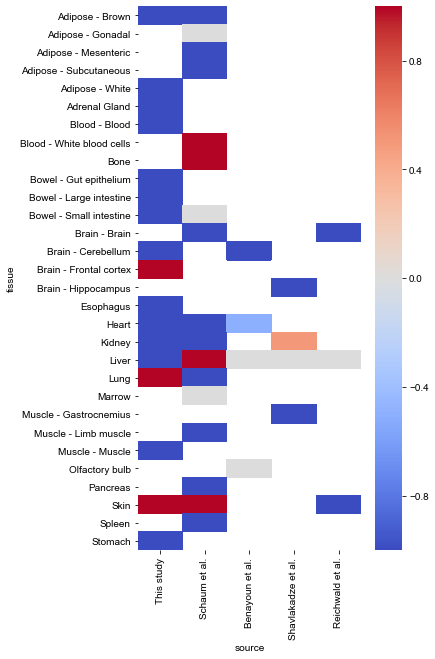

In [42]:
plt.figure(figsize=(5, 10))
v = natsorted(df_c.index)
v_c = ['This study', 'Schaum et al.', 'Benayoun et al.', 'Shavlakadze et al.', 'Reichwald et al.']
sns.heatmap(
    df_c.fillna(0).reindex(index=v, columns=v_c), 
    cmap='coolwarm',
    mask=is_null.reindex(index=v, columns=v_c), 
    xticklabels=True,
    yticklabels=True)

if save_images:
    export.export_image(
        '{}/only_model_organisms.pdf'.format(
            outfolder))


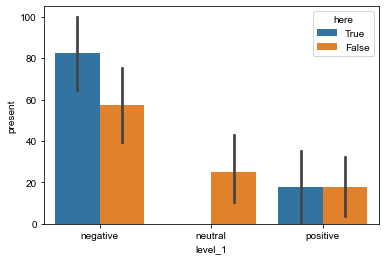

In [43]:
toy = df_c.stack().to_frame('sign').reset_index().rename(columns={'level_1': 'study'})

toy.loc[:, 'negative'] = toy['sign']<0
toy.loc[:, 'positive'] = toy['sign']>0
toy.loc[:, 'neutral'] = toy['sign']==0

toy['here'] = toy['source'] == 'This study'

toy = toy[['here', 'negative', 'positive', 'neutral']].set_index(
    'here').stack().to_frame('present').reset_index()

sns.barplot(x='level_1', y='present', hue='here', data=toy, 
            hue_order=[True, False],
            order=['negative', 'neutral', 'positive'],
            estimator=lambda x: np.mean(x*100)
           )

if save_images:
    export.export_image(
        '{}/own_and_other_study.pdf'.format(
            outfolder))

In [44]:
toy['here'].value_counts()/3

False    28.0
True     17.0
Name: here, dtype: float64

In [45]:
df_c['This study'].notnull().sum()

17

In [46]:
toy.groupby(['level_1', 'here', 'present']).size()

level_1   here   present
negative  False  False      12
                 True       16
          True   False       3
                 True       14
neutral   False  False      21
                 True        7
          True   False      17
positive  False  False      23
                 True        5
          True   False      14
                 True        3
dtype: int64

In [47]:
14/17

0.8235294117647058

In [48]:
from scipy.stats import fisher_exact

In [49]:
fisher_exact(
    (
        (14, 3),
        (16, 12)
    ),
    alternative='two-sided'


)

(3.5, 0.10973155727861728)

In [50]:
toy.groupby(['level_1', 'here']).sum()

present
level_1  here          
negative False     16.0
         True      14.0
neutral  False      7.0
         True       0.0
positive False      5.0
         True       3.0

In [51]:
# p = inout.get_internal_path(
#     'dynamic/tstoeger/{}/female_and_male_gtex.xlsx'.format(infolder))

# df_h = pd.read_excel(p, skipfooter=3)
# df_h = df_h.sort_values('Tissue')
# df_h = df_h.set_index('Tissue')



In [52]:
p = inout.get_internal_path(
    'figures/tstoeger/material/220127_export_human_tissue_effects/stable_5_gtex_females.xlsx'
)
d1 = pd.read_excel(p)

In [53]:
d1 = d1[d1['comparison']=='20/30 to 60/70']

In [54]:
a = d1.rename(columns={'rho': 'effect'})[['tissue', 'effect', 'pval']]
a.loc[:, 'source'] = 'Human females - GTEx'

In [55]:
agg_collect_studies.append(a)

In [56]:
p = inout.get_internal_path(
    'figures/tstoeger/material/220127_export_human_tissue_effects/stable_6_gtex_males.xlsx'
)
d2 = pd.read_excel(p)

d2 = d2[d2['comparison']=='20/30 to 60/70']
a = d2.rename(columns={'rho': 'effect'})[['tissue', 'effect', 'pval']]
a.loc[:, 'source'] = 'Human males - GTEx'




In [57]:
agg_collect_studies.append(a)

In [58]:
df_m = pd.concat(agg_collect_studies)




df_m.loc[:, 'benjamini_hochberg'] = multipletests(
    df_m.loc[:, 'pval'].values, method='fdr_bh')[1]

f = (df_m['effect'] < 0) & (df_m['pval'] < 0.01)
df_m.loc[f, 'code'] = -0.5

f = (df_m['effect'] > 0) & (df_m['pval'] < 0.01)
df_m.loc[f, 'code'] = +0.5

f = (df_m['effect'] < 0) & (df_m['benjamini_hochberg'] < 0.01)
df_m.loc[f, 'code'] = -1

f = (df_m['effect'] > 0) & (df_m['benjamini_hochberg'] < 0.01)
df_m.loc[f, 'code'] = +1

df_m.loc[:, 'code'] = df_m.loc[:, 'code'].fillna(0)

df_c = df_m.pivot(index='tissue', columns='source', values='code')



is_null = df_c.isnull()

In [59]:
df_c

source,Benayoun et al.,Human females - GTEx,Human males - GTEx,Reichwald et al.,Schaum et al.,Shavlakadze et al.,This study
tissue,,,,,,,
Adipose - Brown,NaN,NaN,NaN,NaN,-1.0,NaN,-1.0
Adipose - Gonadal,NaN,NaN,NaN,NaN,0.0,NaN,NaN
Adipose - Mesenteric,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
Adipose - Subcutaneous,NaN,1.0,-1.0,NaN,-1.0,NaN,NaN
Adipose - Visceral (Omentum),NaN,1.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
Testis,NaN,NaN,0.0,NaN,NaN,NaN,NaN
Thyroid,NaN,-1.0,-1.0,NaN,NaN,NaN,NaN
Uterus,NaN,-1.0,NaN,NaN,NaN,NaN,NaN


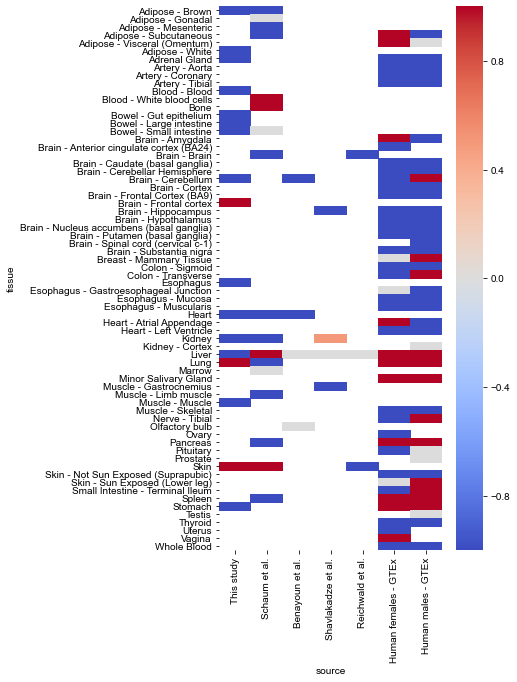

In [60]:
plt.figure(figsize=(5, 10))
v = natsorted(df_c.index)
v_c = ['This study', 'Schaum et al.', 'Benayoun et al.', 'Shavlakadze et al.', 'Reichwald et al.',
      'Human females - GTEx', 'Human males - GTEx'
      
      ]
sns.heatmap(
    df_c.fillna(0).reindex(index=v, columns=v_c), 
    cmap='coolwarm',
    mask=is_null.reindex(index=v, columns=v_c), 
    xticklabels=True,
    yticklabels=True)

if save_images:
    export.export_image(
        '{}/with_human.pdf'.format(
            outfolder))

In [61]:
df_m[df_m['code']==-0.5]

,tissue,effect,pval,source,benjamini_hochberg,code


In [62]:
df_m[df_m['code']==+0.5]

,tissue,effect,pval,source,benjamini_hochberg,code
2,Kidney,0.0574679,0.00955008,Shavlakadze et al.,0.010785,0.5


In [63]:
a = df_m.copy()
f = a['source'].str.startswith('Human')
a.loc[f, 'hue'] = 'GTEx (all)'
a.loc[~f, 'hue'] = 'Model organisms'

In [64]:
f = a['source'].str.startswith('Human') & a['tissue'].str.startswith('Brain')

In [65]:
b = a[f]
b.loc[:, 'hue'] = 'GTEx (brain)'
tog = pd.concat([a, b])

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [66]:
tog['n'] = tog['source'] + '_' + tog['tissue']

In [67]:
tog['negative'] = tog['code'] < 0
tog['positive'] = tog['code'] > 0
tog['neutral'] = tog['code'] == 0

In [68]:
m = tog.set_index('hue')[['negative', 'positive', 'neutral']].stack().to_frame('present').rename_axis(
    ['hue', 'direction']
).reset_index()

In [69]:
m

,hue,direction,present
0,Model organisms,negative,True
1,Model organisms,positive,False
2,Model organisms,neutral,False
3,Model organisms,negative,True
4,Model organisms,positive,False
...,...,...,...
460,GTEx (brain),positive,False
461,GTEx (brain),neutral,False
462,GTEx (brain),negative,True
463,GTEx (brain),positive,False


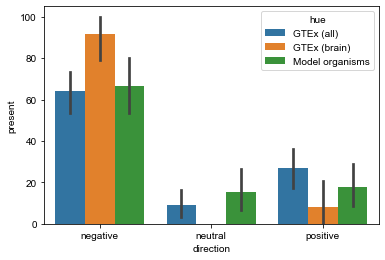

In [70]:

sns.barplot(
    x='direction', y='present', hue='hue', data=m,
    order=['negative', 'neutral', 'positive'],
    hue_order=['GTEx (all)', 'GTEx (brain)', 'Model organisms'],
    estimator=lambda x: np.mean(x*100)
)

if save_images:
    export.export_image(
        '{}/GTEx_bars.pdf'.format(
            outfolder))

In [71]:
m['hue'].value_counts() / 3

GTEx (all)         86.0
Model organisms    45.0
GTEx (brain)       24.0
Name: hue, dtype: float64